In [1]:
print("all ok")

all ok


In [2]:
import sys, os

# Get project root — one level up from 'research_and_analyst'
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)

print("Project root added to path:", project_root)

Project root added to path: /home/krishna/Documents/krishna/llmops_krishnaik/automated-research-report-generation


In [3]:
from research_and_analyst.utils.model_loader import ModelLoader

In [4]:
model_loader = ModelLoader()

{"timestamp": "2025-11-08T16:08:55.959847Z", "level": "info", "event": "GOOGLE_API_KEY loaded from environment"}
{"timestamp": "2025-11-08T16:08:55.961080Z", "level": "info", "event": "GROQ_API_KEY loaded from environment"}
{"timestamp": "2025-11-08T16:08:55.961800Z", "level": "info", "event": "ASTRA_DB_API_ENDPOINT loaded from environment"}
{"timestamp": "2025-11-08T16:08:55.962701Z", "level": "info", "event": "ASTRA_DB_APPLICATION_TOKEN loaded from environment"}
{"timestamp": "2025-11-08T16:08:55.963245Z", "level": "info", "event": "ASTRA_DB_KEYSPACE loaded from environment"}
{"config_keys": ["astra_db", "embedding_model", "retriever", "llm"], "timestamp": "2025-11-08T16:08:55.965276Z", "level": "info", "event": "YAML config loaded"}


In [5]:
llm = model_loader.load_llm()

{"provider": "google", "model": "gemini-2.0-flash", "timestamp": "2025-11-08T16:08:55.972118Z", "level": "info", "event": "Loading LLM"}
E0000 00:00:1762618135.982082  128898 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [6]:
# llm.invoke("hi").content

In [7]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

In [8]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver

Analyst( name="Dr. Neha Patel", role="Medical Data Scientist", affiliation="Stanford Medicine", description="Focuses on predictive models for patient outcomes." ),

Analyst( name="Dr. Arun Verma", role="Ethics Researcher", affiliation="WHO", description="Explores ethical implications of AI in diagnostics." ), Analyst( name="Ms. Priya Sharma", role="Policy Analyst", affiliation="Ministry of Health", description="Investigates AI policy and compliance frameworks." )

In [9]:
class Analyst(BaseModel):
    name: str = Field(description="Name of the analyst")
    role: str = Field(description="Role of the analyst in the context of the topic")
    affiliation: str = Field(description="Primary affiliation of the analyst")
    description: str = Field(description="Description of the analyst: focus, concerns and motives")

    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\ndescription: {self.description}"

In [10]:
analyst = Analyst(
    name="Krishna", 
    role="GenAI Engineer", 
    affiliation="AI Research Lab", 
    description="I am a GenAI developer."
)

In [11]:
analyst.name

'Krishna'

In [12]:
print(analyst.persona)

Name: Krishna
Role: GenAI Engineer
Affiliation: AI Research Lab
description: I am a GenAI developer.


In [13]:
Analyst(
    name="Dr. Neha Patel",
    role="Medical Data Scientist",
    affiliation="Stanford Medicine",
    description="Focuses on predictive models for patient outcomes."
)

Analyst(name='Dr. Neha Patel', role='Medical Data Scientist', affiliation='Stanford Medicine', description='Focuses on predictive models for patient outcomes.')

In [14]:
class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(description="Comprehensive list of analysts with their roles and affiliations.")

In [15]:
class GenerateAnalystsState(TypedDict):
    topic: str    # research topic
    max_analysts: int    # number of analyst
    human_analyst_feedback: str    # human feedback
    analysts: List[Analyst]    # analyst asking questions

In [16]:
GenerateAnalystsState(
    topic = "finance",
    max_analysts= 5,
    human_analyst_feedback= "give the real info",  
)

{'topic': 'finance',
 'max_analysts': 5,
 'human_analyst_feedback': 'give the real info'}

In [17]:
analyst_instructions = """You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

In [18]:
print([analyst_instructions.format(
        topic="education",
        max_analysts=4,
        human_analyst_feedback="please exaplain only on AI"
        )] + ["Generate the set of analysts."])

['You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:\n\n1. First, review the research topic:\neducation\n\n2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: \n\nplease exaplain only on AI\n\n3. Determine the most interesting themes based upon documents and / or feedback above.\n\n4. Pick the top 4 themes.\n\n5. Assign one analyst to each theme.', 'Generate the set of analysts.']


In [19]:
def create_analyst(state: GenerateAnalystsState):
    """
    it is creating my analyst.
    """
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback", "")

    structured_llm = llm.with_structured_output(Perspectives)    # structured_llm will return an output in the form of Perspectives.

    system_messages = analyst_instructions.format(
        topic=topic, 
        max_analysts=max_analysts,
        human_analyst_feedback=human_analyst_feedback
    )

    analysts = structured_llm.invoke([SystemMessage(content=system_messages)] + [HumanMessage(content="Generate the set of analysts.")])

    return {"analysts": analysts.analysts}

In [20]:
create_analyst(
    {'topic': 'health',
    'max_analysts': 2,
    'human_analyst_feedback': 'give the real info'}
    )

{'analysts': [Analyst(name='Dr. Emily Carter', role='Public Health Researcher', affiliation='National Institutes of Health', description='Focuses on preventative healthcare and health equity. Concerned about disparities in access to care and the impact of social determinants on health outcomes. Motivated by a desire to improve population health and reduce health inequalities.'),
  Analyst(name='Dr. David Chen', role='Healthcare Policy Analyst', affiliation='Center for Health Policy Studies', description='Specializes in healthcare policy and regulation. Concerned about the rising costs of healthcare and the efficiency of healthcare delivery systems. Motivated by a desire to promote evidence-based policymaking and improve the affordability and accessibility of healthcare.')]}

In [21]:
def human_feedback(state):
    """
    No-op node that should be interrupted on
    """
    pass

In [22]:
def should_continue(state):
    feedback = (state.get("human_analyst_feedback") or "").strip().lower()
    if feedback and feedback not in ["", "none", "skip", "done", "continue"]:
        return "create_analyst"
    return END

In [23]:
# to display the graph
from IPython.display import Image, display

## First Workflow

In [24]:
builder = StateGraph(GenerateAnalystsState)

In [25]:
builder.add_node("create_analyst", create_analyst)
builder.add_node("human_feedback", human_feedback)

In [26]:
builder.add_edge(START, "create_analyst")

In [27]:
builder.add_edge("create_analyst", "human_feedback")
builder.add_conditional_edges("human_feedback", 
                              should_continue, 
                              ["create_analyst", 
                               END])

In [28]:
memory = MemorySaver()

In [29]:
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)

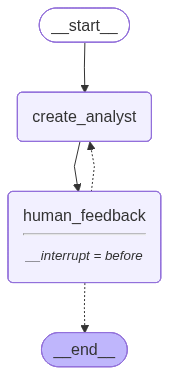

In [30]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [31]:
topic = "the benefits of adopting Langgraph as an agent framework"

In [32]:
max_analysts = 1

In [33]:
thread =  {"configurable":{"thread_id":1}}

In [34]:
for event in graph.stream({"topic": topic, "max_analysts": max_analysts}, thread, stream_mode="values"):
    analysts = event.get("analysts", "")

    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Ava Lovelace
Affiliation: TechForward Solutions
Role: AIops Engineer
Description: Focuses on the practical implementation and operational aspects of Langgraph. Concerned with its scalability, monitoring, and integration into existing infrastructure. Motivated by ensuring reliability and efficiency in AI deployments.
--------------------------------------------------


In [35]:
state = graph.get_state(thread)

In [36]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 1, 'analysts': [Analyst(name='Ava Lovelace', role='AIops Engineer', affiliation='TechForward Solutions', description='Focuses on the practical implementation and operational aspects of Langgraph. Concerned with its scalability, monitoring, and integration into existing infrastructure. Motivated by ensuring reliability and efficiency in AI deployments.')]}, next=('human_feedback',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0bcbd3-ccac-66d0-8001-b2095159bf98'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-11-08T16:09:00.324808+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0bcbd3-bd10-6b26-8000-e2d9cbf4f4e6'}}, tasks=(PregelTask(id='19b62899-9b1f-f77a-7e78-731047853e68', name='human_feedback', path=('__pregel_pull', 'human_feedback'), error=None, interrupts=(), 

In [37]:
state.values

{'topic': 'the benefits of adopting Langgraph as an agent framework',
 'max_analysts': 1,
 'analysts': [Analyst(name='Ava Lovelace', role='AIops Engineer', affiliation='TechForward Solutions', description='Focuses on the practical implementation and operational aspects of Langgraph. Concerned with its scalability, monitoring, and integration into existing infrastructure. Motivated by ensuring reliability and efficiency in AI deployments.')]}

In [38]:
state.next

('human_feedback',)

In [39]:
memory.storage.items()

dict_items([('1', defaultdict(<class 'dict'>, {'': {'1f0bcbd3-bd0e-6f62-bfff-955c54e9367e': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2025-11-08T16:08:58.687461+00:00\xa2id\xd9$1f0bcbd3-bd0e-6f62-bfff-955c54e9367e\xb0channel_versions\x81\xa9__start__\xd9400000000000000000000000000000001.0.05927252717392195\xadversions_seen\x81\xa9__input__\x80\xb0updated_channels\x91\xa9__start__'), ('msgpack', b'\x83\xa6source\xa5input\xa4step\xff\xa7parents\x80'), None), '1f0bcbd3-bd10-6b26-8000-e2d9cbf4f4e6': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2025-11-08T16:08:58.688167+00:00\xa2id\xd9$1f0bcbd3-bd10-6b26-8000-e2d9cbf4f4e6\xb0channel_versions\x84\xa9__start__\xd9300000000000000000000000000000002.0.2998552784463324\xa5topic\xd9300000000000000000000000000000002.0.2998552784463324\xacmax_analysts\xd9300000000000000000000000000000002.0.2998552784463324\xb8branch:to:create_analyst\xd9300000000000000000000000000000002.0.2998552784463324\xadversions_seen\x82\xa9__input__\x80\xa9__start__\x81\xa9__start__\x

In [40]:
state.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0bcbd3-ccac-66d0-8001-b2095159bf98'}}

In [41]:
graph.update_state(thread,
                   {"human_analyst_feedback":"add something from the startup perspective and focus on the latest enterprise application"}, as_node="human_feedback"
                   )

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0bcbd3-cd87-6427-8002-b46a3b958ad2'}}

In [42]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Ava Lovelace
Affiliation: TechForward Solutions
Role: AIops Engineer
Description: Focuses on the practical implementation and operational aspects of Langgraph. Concerned with its scalability, monitoring, and integration into existing infrastructure. Motivated by ensuring reliability and efficiency in AI deployments.
--------------------------------------------------
Name: Ava Chen
Affiliation: InnovateAI Solutions
Role: Startup CTO
Description: Focuses on leveraging Langgraph to rapidly prototype and deploy AI-powered solutions, reducing time-to-market for new products. Concerned with the initial investment and integration efforts required for a startup environment. Motivated by the potential for increased agility and competitive advantage.
--------------------------------------------------


In [43]:
state = graph.get_state(thread)

In [44]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 1, 'human_analyst_feedback': 'add something from the startup perspective and focus on the latest enterprise application', 'analysts': [Analyst(name='Ava Chen', role='Startup CTO', affiliation='InnovateAI Solutions', description='Focuses on leveraging Langgraph to rapidly prototype and deploy AI-powered solutions, reducing time-to-market for new products. Concerned with the initial investment and integration efforts required for a startup environment. Motivated by the potential for increased agility and competitive advantage.')]}, next=('human_feedback',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0bcbd3-de8a-6626-8005-522c58859abb'}}, metadata={'source': 'loop', 'step': 5, 'parents': {}}, created_at='2025-11-08T16:09:02.198296+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0bcbd3-cda2-62a

In [45]:
state.next

('human_feedback',)

In [46]:
state.values

{'topic': 'the benefits of adopting Langgraph as an agent framework',
 'max_analysts': 1,
 'human_analyst_feedback': 'add something from the startup perspective and focus on the latest enterprise application',
 'analysts': [Analyst(name='Ava Chen', role='Startup CTO', affiliation='InnovateAI Solutions', description='Focuses on leveraging Langgraph to rapidly prototype and deploy AI-powered solutions, reducing time-to-market for new products. Concerned with the initial investment and integration efforts required for a startup environment. Motivated by the potential for increased agility and competitive advantage.')]}

In [47]:
further_feedack = ""

In [48]:
# 1) Get the latest state (you're paused at 'human_feedback')
state = graph.get_state(thread)

# 2) Use the exact config from that state (it already has thread_id, checkpoint_ns, checkpoint_id)
cfg = state.config

In [49]:
# 3) Update feedback at the 'human_feedback' node
#    Tip: if your TypedDict says `human_analyst_feedback: str`, prefer "" (empty string) over None
graph.update_state(cfg, {"human_analyst_feedback": ""}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0bcbd3-df3a-66ab-8006-7b89eb995fd7'}}

In [50]:
# 4) Verify it moved to END
final_state = graph.get_state(thread)
print(final_state.next)  # should be (END,)

()


In [51]:
analysts = final_state.values.get('analysts')
analysts

[Analyst(name='Ava Chen', role='Startup CTO', affiliation='InnovateAI Solutions', description='Focuses on leveraging Langgraph to rapidly prototype and deploy AI-powered solutions, reducing time-to-market for new products. Concerned with the initial investment and integration efforts required for a startup environment. Motivated by the potential for increased agility and competitive advantage.')]

In [52]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Ava Chen
Affiliation: InnovateAI Solutions
Role: Startup CTO
Description: Focuses on leveraging Langgraph to rapidly prototype and deploy AI-powered solutions, reducing time-to-market for new products. Concerned with the initial investment and integration efforts required for a startup environment. Motivated by the potential for increased agility and competitive advantage.
--------------------------------------------------


In [53]:
from langchain_community.document_loaders import WikipediaLoader

# docs = WikipediaLoader(query="The benefits of adopting LangGraph as an agent framework").load()
# print(docs[0].page_content[:500])

In [54]:
# from langchain_community.utilities import WikipediaAPIWrapper

# wiki = WikipediaAPIWrapper(top_k_results=2, doc_content_chars_max=4000)
# docs = wiki.run("The benefits of adopting LangGraph as an agent framework")
# print(docs)

## Second Workflow

In [55]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [56]:
from dotenv import load_dotenv
load_dotenv()
import os
tavily_api_key = os.getenv("TAVILY_API_KEY")

In [57]:
tavily_search = TavilySearchResults(tavily_api_key=tavily_api_key)

/tmp/ipykernel_128898/1029971610.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(tavily_api_key=tavily_api_key)


In [58]:
# tavily_search.invoke("langgraph")

In [59]:
# from langchain_community.document_loaders import WikipediaLoader

# docs = WikipediaLoader(query="LangGraph").load()
# print(docs[0].page_content[:500])

In [60]:
from typing import Annotated
import operator
from langgraph.graph import MessagesState

In [61]:
class InterviewState(MessagesState):
    max_num_turns: int    # number of turns of conversation
    context: Annotated[list, operator.add]    # source docs
    analyst: Analyst    # analyst asking questions
    interview: str    # interview transcript
    sections: list    # final key we duplicate in outer state for Send() API

In [62]:
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval")

In [63]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic.

Your goal is to boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.

2. Specific: Insights that avoid generalitites and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}

Begin by intoducing yourself to drill down and refine your understanding of the topic.

When you are satisfied with your understanding, complete the interview: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you.

"""

In [64]:
def generate_question(state: InterviewState):
    """
    Node to generate question
    """
    # get state
    analyst = state["analyst"]
    messages = state["messages"]

    # generate the question
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)

    # return the question through state
    return {"messages": [question]}

In [65]:
analyst

Analyst(name='Ava Chen', role='Startup CTO', affiliation='InnovateAI Solutions', description='Focuses on leveraging Langgraph to rapidly prototype and deploy AI-powered solutions, reducing time-to-market for new products. Concerned with the initial investment and integration efforts required for a startup environment. Motivated by the potential for increased agility and competitive advantage.')

In [66]:
state = {"max_num_turns": 2, "context": [], "analyst": analyst, "interview": "", "section": [], "messages": [HumanMessage(content="hi fo the proper search according to the expertise")]}
state

{'max_num_turns': 2,
 'context': [],
 'analyst': Analyst(name='Ava Chen', role='Startup CTO', affiliation='InnovateAI Solutions', description='Focuses on leveraging Langgraph to rapidly prototype and deploy AI-powered solutions, reducing time-to-market for new products. Concerned with the initial investment and integration efforts required for a startup environment. Motivated by the potential for increased agility and competitive advantage.'),
 'interview': '',
 'section': [],
 'messages': [HumanMessage(content='hi fo the proper search according to the expertise', additional_kwargs={}, response_metadata={})]}

In [67]:
result = generate_question(state)

In [68]:
result

{'messages': [AIMessage(content="Okay, great! Hi Ava, my name is Alex, and I'm an analyst looking to understand the practical applications and challenges of using Langgraph in a startup environment. Specifically, I'm interested in how it impacts the speed of development and deployment of AI solutions, and what kind of initial investment and integration efforts are typically required.\n\nBefore we dive in, could you tell me a bit more about the specific types of AI-powered solutions InnovateAI Solutions is building with Langgraph? Are we talking about chatbots, data analysis tools, or something else entirely? Also, what were you using *before* Langgraph, and what were the biggest pain points you were hoping to solve by switching? This will help me frame my questions and get the most relevant insights from our conversation.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 's

In [69]:
print(result["messages"][0].content)

Okay, great! Hi Ava, my name is Alex, and I'm an analyst looking to understand the practical applications and challenges of using Langgraph in a startup environment. Specifically, I'm interested in how it impacts the speed of development and deployment of AI solutions, and what kind of initial investment and integration efforts are typically required.

Before we dive in, could you tell me a bit more about the specific types of AI-powered solutions InnovateAI Solutions is building with Langgraph? Are we talking about chatbots, data analysis tools, or something else entirely? Also, what were you using *before* Langgraph, and what were the biggest pain points you were hoping to solve by switching? This will help me frame my questions and get the most relevant insights from our conversation.


In [70]:
from langchain_core.messages import get_buffer_string

In [71]:
# search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert.
Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
Firstly, analyze the full conversation.
Pay particular attention to the final question posed by the analyst.
Convert this final question into a well-structured web search query.
""")

In [72]:
def search_web(state: InterviewState):
    """
    Retrieve data from the web
    """
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state["messages"])

    # web search
    search_docs = tavily_search.invoke(search_query.search_query)

    # format
    formatted_search_docs = "\n\n----\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

In [73]:
state = {"max_num_turns": 2, "context": [], "analyst": analyst, "interview": "", "section": [], 'messages': [AIMessage(content='Okay, great! Hi Carlos, my name is [Your Name], and I\'m an analyst working on understanding the current landscape and future potential of Langgraph-based solutions, particularly from a product and market adoption perspective.\n\nI understand you\'re an AI Product Manager at DataWise Analytics, focusing on developing and launching AI-powered products. That makes you the perfect person to talk to!\n\nTo make sure I\'m focusing my questions in the right area, could you tell me a bit more about the specific types of Langgraph-based solutions you\'re currently working with or have experience with? Are we talking about things like:\n\n*   **Complex conversational AI agents?** (e.g., multi-turn dialogues, agents that can handle interruptions and context switching)\n*   **Automated workflows and decision-making systems?** (e.g., using Langgraph to orchestrate different AI models and tools for tasks like fraud detection or risk assessment)\n*   **Something else entirely?**\n\nAlso, when you think about "usability and market adoption," what are the *biggest* challenges that come to mind for you with Langgraph specifically? This will help me narrow down my focus and ask more relevant questions.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--cb7d6132-1cc5-4521-a9ed-bf873c98265d-0', usage_metadata={'input_tokens': 215, 'output_tokens': 253, 'total_tokens': 468, 'input_token_details': {'cache_read': 0}})]}

In [74]:
result = search_web(state)
result

{'context': ['<Document href="https://www.linkedin.com/posts/susil-j_agenticai-langgraph-aiimplementation-activity-7380595306687598592-T8-q"/>\nThe persistent ambition to create truly adaptive enterprise software—systems capable of autonomously modifying their behavior and structure in response to dynamic environments—has largely remained unfulfilled. While research has produced sophisticated control loop architectures and adaptive algorithms, their adoption in complex enterprise settings is fraught with challenges. The primary impediment isn’t procedural but ontological. The prevailing architectural paradigm, rooted in highly [...] The 5 hidden challenges of LangGraph no one talks about: LangGraph has quickly become the premier framework for building sophisticated AI agents - but my conversations with dozens of developers reveal consistent implementation hurdles that aren\'t addressed in tutorials. 1. API Infrastructure Gaps The open-source version lacks built-in API endpoints, forcin

In [75]:
print(result["context"][0])

<Document href="https://www.linkedin.com/posts/susil-j_agenticai-langgraph-aiimplementation-activity-7380595306687598592-T8-q"/>
The persistent ambition to create truly adaptive enterprise software—systems capable of autonomously modifying their behavior and structure in response to dynamic environments—has largely remained unfulfilled. While research has produced sophisticated control loop architectures and adaptive algorithms, their adoption in complex enterprise settings is fraught with challenges. The primary impediment isn’t procedural but ontological. The prevailing architectural paradigm, rooted in highly [...] The 5 hidden challenges of LangGraph no one talks about: LangGraph has quickly become the premier framework for building sophisticated AI agents - but my conversations with dozens of developers reveal consistent implementation hurdles that aren't addressed in tutorials. 1. API Infrastructure Gaps The open-source version lacks built-in API endpoints, forcing developers to 

In [76]:
def search_wikipedia(state: InterviewState):
    """
    Retrieve data from wikipedia
    """
    # search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state["messages"])
    print(f"search_query: {search_query}")

    # search
    search_docs = WikipediaLoader(query=search_query.search_query,
                                  load_max_docs=2).load()
    print(f"search_docs: {search_docs}")

    # format
    formatted_search_docs = "\n\n----\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

In [77]:
state = {"max_num_turns": 2, "context": [], "analyst": analyst, "interview": "", "section": [], 'messages': [AIMessage(content='Okay, great! Hi Carlos, my name is [Your Name], and I\'m an analyst working on understanding the current landscape and future potential of Langgraph-based solutions, particularly from a product and market adoption perspective.\n\nI understand you\'re an AI Product Manager at DataWise Analytics, focusing on developing and launching AI-powered products. That makes you the perfect person to talk to!\n\nTo make sure I\'m focusing my questions in the right area, could you tell me a bit more about the specific types of Langgraph-based solutions you\'re currently working with or have experience with? Are we talking about things like:\n\n*   **Complex conversational AI agents?** (e.g., multi-turn dialogues, agents that can handle interruptions and context switching)\n*   **Automated workflows and decision-making systems?** (e.g., using Langgraph to orchestrate different AI models and tools for tasks like fraud detection or risk assessment)\n*   **Something else entirely?**\n\nAlso, when you think about "usability and market adoption," what are the *biggest* challenges that come to mind for you with Langgraph specifically? This will help me narrow down my focus and ask more relevant questions.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--cb7d6132-1cc5-4521-a9ed-bf873c98265d-0', usage_metadata={'input_tokens': 215, 'output_tokens': 253, 'total_tokens': 468, 'input_token_details': {'cache_read': 0}})]}

In [78]:
result = search_wikipedia(state)    # getting empty search docs from wikipedia for this query
result

search_query: search_query='challenges of Langgraph usability and market adoption'
search_docs: []


{'context': ['']}

In [79]:
answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

In [80]:
def generate_answer(state: InterviewState):
    """
    Node to answer a question
    """
    # get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # answer question
    system_message = question_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)

    # name the message as coming from expert
    answer.name = "expert"

    # append it to state
    return {"messages": [answer]}

In [81]:
def router_messages(state: InterviewState,
                    name: str = "expert"):
    """
    Route between question and answer
    """
    # get messages
    messages = state["messages"]
    max_num_turns = state.get("max_num_turns", 2)

    # check the number of expert answers
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # end if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return "save_interview"
    
    # this router is run after each question - answer pair 
    # get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    
    return "ask_question"

In [82]:
def save_interview(state: InterviewState):
    """
    Save interviews
    """
    # get messages
    messages = state["messages"]

    # convert interview to a string
    interview = get_buffer_string(messages)

    # save to interview key
    return {"interview": interview}

In [83]:
section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

In [84]:
def write_section(state: InterviewState):
    """
    """
    # get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # append it to state
    return {"sections": [section.content]}

In [85]:
interview_builder = StateGraph(InterviewState)

In [86]:
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("generate_answer", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

In [87]:
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "generate_answer")
interview_builder.add_edge("search_wikipedia", "generate_answer")
interview_builder.add_conditional_edges("generate_answer",
                           router_messages,
                           ["ask_question",
                           "save_interview"])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

In [88]:
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interview")

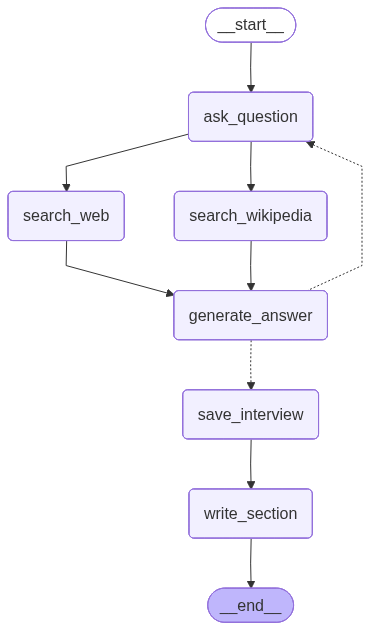

In [89]:
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [90]:
analyst

Analyst(name='Ava Chen', role='Startup CTO', affiliation='InnovateAI Solutions', description='Focuses on leveraging Langgraph to rapidly prototype and deploy AI-powered solutions, reducing time-to-market for new products. Concerned with the initial investment and integration efforts required for a startup environment. Motivated by the potential for increased agility and competitive advantage.')

In [91]:
from IPython.display import Markdown

In [92]:
messages = [HumanMessage("So you said you were writing an article on Langchain?")]

In [93]:
thread = {"configurable": {"thread_id": "1"}}

In [94]:
interview = interview_graph.invoke({"analyst": analyst, "messages": messages, "max_num_turns": 2}, thread)

search_query: search_query='LangGraph practical applications in startups'
search_docs: [Document(metadata={'title': 'Social network analysis', 'summary': 'Social network analysis (SNA) is the process of investigating social structures through the use of networks and graph theory. It characterizes networked structures in terms of nodes (individual actors, people, or things within the network) and the ties, edges, or links (relationships or interactions) that connect them. Examples of social structures commonly visualized through social network analysis include social media networks, meme proliferation, information circulation, friendship and acquaintance networks, business networks, knowledge networks, difficult working relationships, collaboration graphs, kinship, disease transmission, and sexual relationships. These networks are often visualized through sociograms in which nodes are represented as points and ties are represented as lines. These visualizations provide a means of qualit

In [95]:
Markdown(interview["sections"][0])

## Accelerating AI Solution Deployment with LangGraph: A Startup's Edge

### Summary

LangGraph, an addition to the LangChain toolkit, has rapidly gained popularity among AI developers for building complex AI agent workflows [3]. It allows developers to orchestrate multiple agents, each with a specific role, to collaborate within a unified graph, offering benefits that would be difficult to achieve with isolated AI bots [8]. This framework is particularly useful in scenarios where simple linear chains are insufficient, such as advanced customer service chatbots [3]. For startups, LangGraph offers the potential to rapidly prototype and deploy AI-powered solutions, thereby reducing time-to-market and increasing agility [1].

However, while LangGraph is open-source and free to download, hidden costs such as engineering time, cloud infrastructure, debugging, and integration can be significant [9]. One analyst noted that the open-source version lacks built-in API endpoints, forcing developers to build their own infrastructure layer from scratch, which can add weeks of development time [7]. Despite these challenges, LangGraph's ability to manage complex workflows, automate decisions, and scale AI solutions makes it a strong foundation for AI initiatives [6]. Its integration flexibility with existing LangChain components and external systems also makes it adaptable to diverse infrastructure setups [5].

LangGraph's ReAct (reasoning + acting) pattern is particularly useful for applications requiring adaptive behavior, such as a startup validation system that dynamically chooses between web search, market analysis, and competitor research [1]. Moreover, LangGraph's design allows developers to inspect the state of the graph at each node, monitor the sequence of actions, and even stream the intermediate results, providing real-time insights into the agent's "thought process" [2]. This capability, combined with human-in-the-loop debugging, facilitates faster iteration and allows for adjustments without restarting the entire process [8].

Ultimately, LangGraph is ideal for complex reasoning workflows that require iterative refinement and validation, as well as decision trees with multiple evaluation criteria and conditional outcomes [5]. While LangChain is suitable for initial explorations and straightforward applications, LangGraph is the better choice when state management, complex flow control, or production-grade reliability are needed [5].

### Sources

[1] https://www.firecrawl.dev/blog/langgraph-startup-validator-tutorial
[2] https://www.scalablepath.com/machine-learning/langgraph
[3] https://www.designveloper.com/blog/what-is-langgraph/
[4] https://blog.langchain.com/customers-harmonic/
[5] https://kanerika.com/blogs/langchain-vs-langgraph/
[6] https://www.ema.co/additional-blogs/addition-blogs/building-ai-agents-langgraph
[7] https://www.linkedin.com/posts/susil-j_agenticai-langgraph-aiimplementation-activity-7380595306687598592-T8-q
[8] https://www.scalablepath.com/machine-learning/langgraph
[9] https://agentiveaiq.com/blog/is-langgraph-free-how-agentiveaiq-beats-open-source

## Third Workflow

In [96]:
from typing_extensions import TypedDict
from typing import List, Annotated
import operator

class ResearchGraphState(TypedDict):
    topic: str    # research topic
    max_analysts: int    # number of analysts
    human_analyst_feedback: str    # human feedback
    analysts: List[Analyst]    # analyst asking questions
    sections: Annotated[list, operator.add]    # Send() API key
    introduction: str    # introduction for the final report
    content: str    # content for the final report
    conclusion: str    # conclusion for the final report
    final_report: str    # final report

In [97]:
from langgraph.types import Send

In [98]:
def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API. """

    # check if human feedback
    human_analyst_feedback = state.get("human_analyst_feedback")
    if human_analyst_feedback:
        # return to create_analyst
        return "create_analyst"
    
    # otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", { "analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )]}) for analyst in state["analysts"]]

In [99]:
# def write_report(state: ResearchGraphState):
#     """
#     """
#     pass

In [100]:
report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

In [101]:
def write_report(state: ResearchGraphState):
    # full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos")])
    return {"content": report.content} 

In [102]:
intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

In [103]:
def write_introduction(state: ResearchGraphState):
    # full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # summarize the sections into a final report
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")])
    return {"introduction": intro.content} 

In [104]:
def write_conclusion(state: ResearchGraphState):
    # full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # summarize the sections into a final report
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")])
    return {"conclusion": conclusion.content} 

In [ ]:
def finalize_report(state: ResearchGraphState):
    """ This is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]    
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

In [106]:
# add nodes and edges
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analyst", create_analyst)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report", write_report)
builder.add_node("write_introduction", write_introduction)
builder.add_node("write_conclusion", write_conclusion)
builder.add_node("finalize_report", finalize_report)

# logic
builder.add_edge(START, "create_analyst")
builder.add_edge("create_analyst", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analyst", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)


In [107]:
memory = MemorySaver()

In [108]:
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)

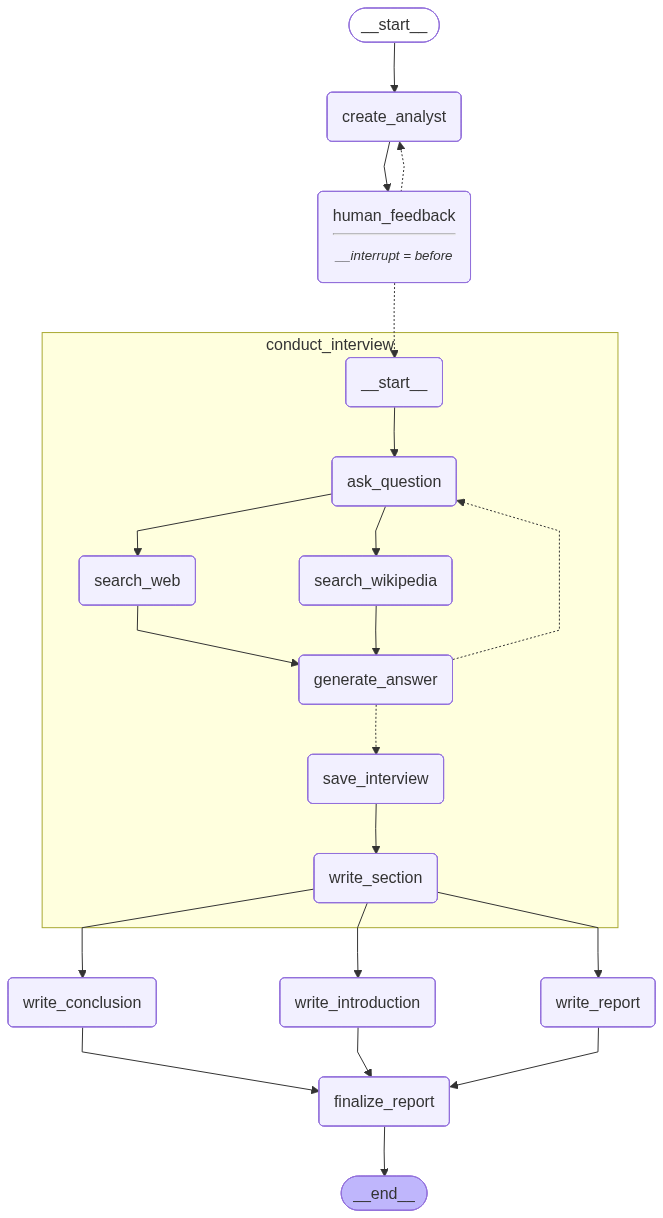

In [109]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [110]:
max_analysts = 1

In [111]:
topic = "How can Generative AI accelerate drug discovery?"

In [112]:
thread = {"configurable": {"thread_id": "1"}}

In [113]:
# run the graph until the first interruption
for event in graph.stream({"topic": topic, "max_analysts": max_analysts}, thread, stream_mode="values"):
    analysts = event.get("analysts", "")
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Anya Sharma
Affiliation: BioAI Solutions
Role: AI Drug Discovery Consultant
Description: Anya focuses on how generative AI can optimize lead compound identification and validation. She is particularly interested in reducing the time and cost associated with early-stage drug discovery. Her concerns involve the accuracy and reliability of AI-generated predictions.
--------------------------------------------------
Name: Dr. Ben Carter
Affiliation: DeepBio Inc.
Role: Generative AI Model Developer
Description: Ben develops generative AI models for novel drug design. His primary focus is on creating AI that can generate diverse and synthesizable drug candidates. He is motivated by the potential to accelerate the drug discovery pipeline but is concerned about the interpretability and validation of these AI models.
--------------------------------------------------


In [114]:
graph.update_state(thread, {"human_analyst_feedback": "Add the future uses of GenAI in the clinical trials also along with drug discovery."}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0bcbd5-386a-663c-8002-a12437faec77'}}

In [115]:
# run the graph until the first interruption
for event in graph.stream({"topic": topic, "max_analysts": max_analysts}, thread, stream_mode="values"):
    analysts = event.get("analysts", "")
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15
Please retry in 21.380840001s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 15
}
, retry_delay {
  sec

Name: Dr. Anya Sharma
Affiliation: BioAI Solutions
Role: AI Drug Discovery Consultant
Description: Anya focuses on how generative AI can optimize lead compound identification and validation. She is particularly interested in reducing the time and cost associated with early-stage drug discovery. Her concerns involve the accuracy and reliability of AI-generated predictions.
--------------------------------------------------
Name: Dr. Ben Carter
Affiliation: DeepBio Inc.
Role: Generative AI Model Developer
Description: Ben develops generative AI models for novel drug design. His primary focus is on creating AI that can generate diverse and synthesizable drug candidates. He is motivated by the potential to accelerate the drug discovery pipeline but is concerned about the interpretability and validation of these AI models.
--------------------------------------------------


ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15
Please retry in 19.274101051s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 15
}
, retry_delay {
  seconds: 19
}
]

In [ ]:
graph.update_state(thread, {"human_analyst_feedback": ""}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0bcb33-e03e-6d91-8006-199b09e84cae'}}

In [ ]:
graph.get_state(thread).next    # 3 conduct_interview in output because of 3 analysts

('conduct_interview',)

In [ ]:
# continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


search_query: search_query='Generative AI applications in drug discovery and development, including clinical trials and data privacy concerns'


HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


search_docs: [Document(metadata={'title': 'Applications of artificial intelligence', 'summary': 'Artificial intelligence is the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, problem-solving, perception, and decision-making. Artificial intelligence (AI) has been used in applications throughout industry and academia. Within the field of Artificial Intelligence, there are multiple subfields. The subfield of Machine learning has been used for various scientific and commercial purposes including language translation, image recognition, decision-making, credit scoring, and e-commerce. In recent years, there have been massive advancements in the field of Generative Artificial Intelligence, which uses generative models to produce text, images, videos or other forms of data. This article describes applications of AI in different sectors.', 'source': 'https://en.wikipedia.org/wiki/Applications_of_artificial_intelli

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


search_query: search_query='Generative AI applications in drug discovery and development including clinical trials and patient data privacy concerns'


HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


search_docs: [Document(metadata={'title': 'Applications of artificial intelligence', 'summary': 'Artificial intelligence is the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, problem-solving, perception, and decision-making. Artificial intelligence (AI) has been used in applications throughout industry and academia. Within the field of Artificial Intelligence, there are multiple subfields. The subfield of Machine learning has been used for various scientific and commercial purposes including language translation, image recognition, decision-making, credit scoring, and e-commerce. In recent years, there have been massive advancements in the field of Generative Artificial Intelligence, which uses generative models to produce text, images, videos or other forms of data. This article describes applications of AI in different sectors.', 'source': 'https://en.wikipedia.org/wiki/Applications_of_artificial_intelli

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.3-70b-versatile` in organization `org_01k0h6wft2fyfrk2zpna6ss6vr` service tier `on_demand` on tokens per day (TPD): Limit 100000, Used 95043, Requested 6178. Please try again in 17m34.944s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

In [ ]:
from IPython.display import Markdown

In [ ]:
final_state = graph.get_state(thread)

In [ ]:
report = final_state.values.get("final_report")

In [ ]:
Markdown(report)

# Accelerating Drug Discovery with Generative AI
## Introduction
Generative AI is transforming the pharmaceutical industry by accelerating drug discovery and clinical trials. It optimizes existing drugs, streamlines trials, and leads to faster treatments. With benefits including improved patient outcomes and reduced adverse reactions, GenAI is revolutionizing the field, but also raises concerns about data privacy and misuse, requiring responsible and ethical use.

----

## Conclusion
The integration of Generative AI in drug discovery and development has the potential to revolutionize the pharmaceutical industry, accelerating the design of new drugs and optimizing existing ones. Key benefits include improved patient outcomes, faster time-to-market, and enhanced drug efficacy. However, concerns around data privacy and misuse must be addressed to ensure responsible and ethical use. Overall, Generative AI can transform clinical trials, leading to more effective treatments and better healthcare outcomes.

## Sources
[1] https://pmc.ncbi.nlm.nih.gov/articles/PMC11444559/ 
[2] https://www.sciencedirect.com/science/article/pii/S135964462400117X 
[3] https://www.frontiersin.org/journals/pharmacology/articles/10.3389/fphar.2024.1331062/full 
[4] https://www.intuz.com/blog/drug-discovery-and-development-using-generative-ai 
[5] https://www.delveinsight.com/blog/generative-ai-drug-discovery-market-impact 
[6] https://www.fda.gov/about-fda/center-drug-evaluation-and-research-cder/artificial-intelligence-drug-development 
[7] https://www.frontiersin.org/journals/pharmacology/articles/10.3389/fphar.2024.1331062/full 
[8] https://www.intuz.com/blog/drug-discovery-and-development-using-generative-ai 
[9] https://www.ppd.com/blog/managing-opportunities-risks-generative-ai-clinical-research/ 
[10] https://www.weforum.org/stories/2024/12/genai-could-transform-clinical-research-trials/ 
[11] https://en.wikipedia.org/wiki/Generative_AI_pornography